In [1]:
from __future__ import annotations

from collections import defaultdict, deque
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

In [2]:
# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

env = gym.make("Blackjack-v1", sab=True)

In [3]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

observation

(11, 10, 0)

In [4]:
# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
class DQNAgent:
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
        batch_size: int = 64,
        replay_memory_capacity: int = 10000,
    ):
        """Initialize a DQN agent.

        Args:
            state_dim: Dimensionality of the state space
            action_dim: Dimensionality of the action space
            learning_rate: The learning rate for the optimizer
            initial_epsilon: The initial epsilon value for exploration
            epsilon_decay: The decay rate for epsilon
            final_epsilon: The final epsilon value for exploration
            discount_factor: The discount factor for computing the Q-value
            batch_size: The batch size for training the DQN
            replay_memory_capacity: The capacity of the replay memory
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.q_network = DQN(state_dim, action_dim).to(self.device)
        self.target_network = DQN(state_dim, action_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()

        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.replay_memory = deque(maxlen=replay_memory_capacity)

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, state: np.ndarray) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.q_network.fc3.out_features)

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return int(torch.argmax(q_values, dim=1).item())

    def update_replay_memory(
        self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool
    ):
        self.replay_memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.replay_memory) < self.batch_size:
            return

        batch = random.sample(self.replay_memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.tensor(state_batch, dtype=torch.float32).to(self.device)
        action_batch = torch.tensor(action_batch, dtype=torch.long).unsqueeze(1).to(self.device)
        reward_batch = torch.tensor(reward_batch, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_state_batch = torch.tensor(next_state_batch, dtype=torch.float32).to(self.device)
        done_batch = torch.tensor(done_batch, dtype=torch.float32).unsqueeze(1).to(self.device)

        with torch.no_grad():
            next_state_values = self.target_network(next_state_batch).max(1)[0].unsqueeze(1)
            target_q_values = reward_batch + (self.discount_factor * next_state_values * (1 - done_batch))

        q_values = self.q_network(state_batch).gather(1, action_batch)
        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.training_error.append(loss.item())

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [7]:
# hyperparameters
state_dim = 3  # player sum, dealer showing, usable ace
action_dim = env.action_space.n
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [8]:
# training loop
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update_replay_memory(obs, action, reward, next_obs, terminated)
        agent.train()

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

c:\Users\valen\miniforge3\envs\deeprl\lib\site-packages\gymnasium\core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
100%|██████████| 100000/100000 [23:28<00:00, 70.97it/s]


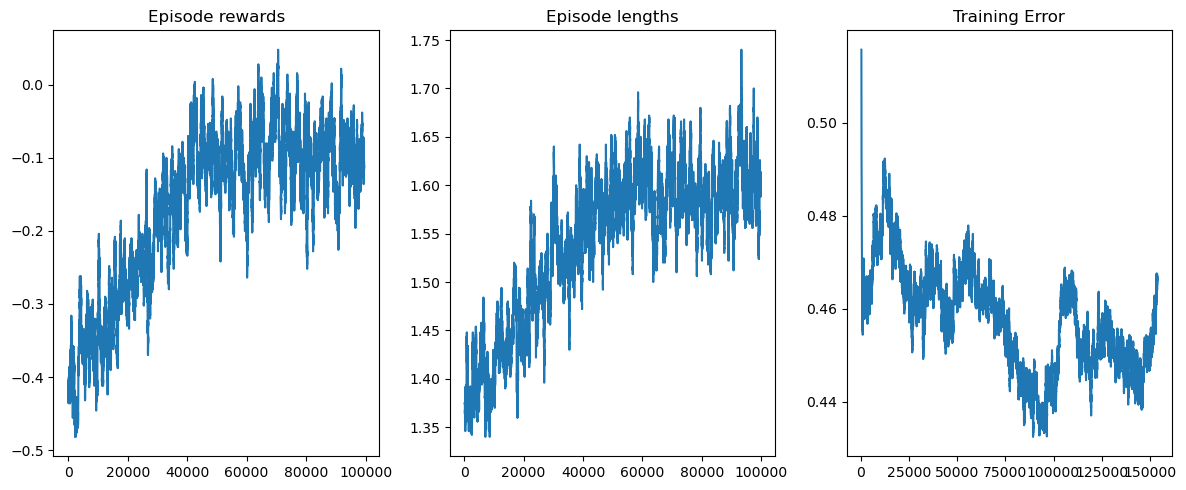

In [9]:
# plotting
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Calculate the length moving average with mode='valid'
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[1].set_title("Episode lengths")
axs[1].plot(
    range(rolling_length // 2, len(length_moving_average) + rolling_length // 2),
    length_moving_average,
)

# Calculate the training error moving average with mode='valid'
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[2].set_title("Training Error")
axs[2].plot(
    range(rolling_length // 2, len(training_error_moving_average) + rolling_length // 2),
    training_error_moving_average,
)

plt.tight_layout()
plt.show()


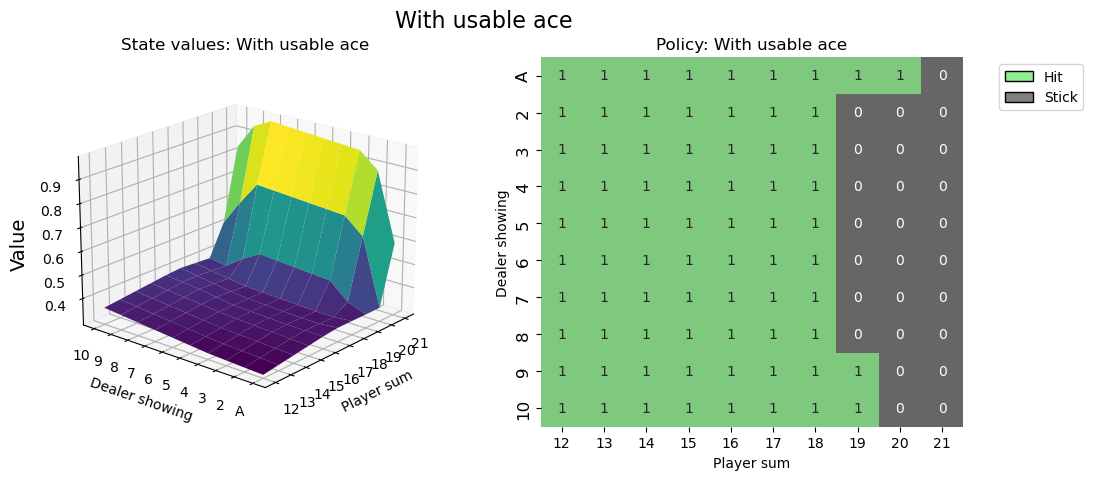

In [11]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for player_sum in range(12, 22):
        for dealer_showing in range(1, 11):
            state = (player_sum, dealer_showing, usable_ace)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                q_values = agent.q_network(state_tensor)
            state_value[state] = float(torch.max(q_values).item())
            policy[state] = int(torch.argmax(q_values, dim=1).item())

    player_count, dealer_count = np.meshgrid(
        np.arange(12, 22),
        np.arange(1, 11),
    )

    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()